# This notebook has 2 tasks
## 1. Analyze the IPA results
## 2. Determine overlap between rat AUD genes and our critical genes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
import seaborn as sns
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
deseq = pd.read_excel(prefix +'/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [9]:
cg_regulators = pd.read_csv(prefix + 'Shared drives/NIAAA_ASSIST/Data/IPA analysis/critical_genes_outputs_upstream_regulators.csv', index_col = 0, encoding = "ISO-8859-1")

In [21]:
neigh_regulators = pd.read_csv(prefix + 'Shared drives/NIAAA_ASSIST/Data/IPA analysis/neighbouring_genes_outputs_upstream_regulators.csv', index_col = 0, encoding = "ISO-8859-1")

# First test: hypergeometric test to determine the probability of getting ~30 overlapping genes between the DEG regulators and critical genes/neighbor genes

In [26]:
from scipy.stats import hypergeom

In [67]:
deg_regulators = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/IPA analysis/deseq_upstream_regulators_unfiltered.csv')
deg_regulators_sig = deg_regulators[deg_regulators['p-value of overlap'] < 0.05]['Upstream Regulator']

In [133]:
len(deg_regulators_sig)

660

In [158]:
[M,n,N] = [19911, 660, 829]

In [159]:
rv = hypergeom(M, n, N)

In [175]:
print('probability of getting 33 genes overlap')
rv.pmf(33)

probability of getting 33 genes overlap


0.041224166911110575

# Second test: bootstrapping to determine the probability of getting 30 overlapping genes

In [5]:
import mygene

In [6]:
network_IDs = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/network_IDs.csv', index_col = 0)

In [7]:
# use mygene to convert ensemble IDs to gene symbols
mg = mygene.MyGeneInfo()
query_data = mg.querymany(list(network_IDs['0']) , scopes='ensembl.gene', fields='symbol', species='human')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-19911...done.
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
687 input query terms found no hit:
	['ENSG00000237683', 'ENSG00000269227', 'ENSG00000271895', 'ENSG00000204377', 'ENSG00000271840', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [8]:
# convert the query data to a dictionary
gene_mapping_dict = {}
for gene in query_data:
    if 'notfound' in gene:
        gene_mapping_dict[gene['query']] = None
    else:
        gene_mapping_dict[gene['query']] = gene['symbol']

all_gene_symbols = network_IDs['0'].map(gene_mapping_dict)

In [162]:
gene_mapping = pd.DataFrame(gene_mapping_dict.items(), columns = ['id','symbol'])
gene_mapping.to_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/gene_mapping_df.csv', index = 0)

In [9]:
cg_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/epoch=100_alpha=0.1_critical_gene_df.csv')

In [10]:
cg_symbols = list(cg_df['gene'].map(gene_mapping_dict))

In [218]:
print('# critical genes overlap with DEG regulators')
len(set(cg_symbols).intersection(deg_regulators_sig))

# critical genes overlap with DEG regulators


33

In [214]:
neighbors_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/top_830_neighbor_genes.csv')

In [216]:
neighbors_symbols = list(neighbors_df['gene'].map(gene_mapping_dict))

In [217]:
print('# neighbor genes overlap with DEG regulators')
len(set(neighbors_symbols).intersection(deg_regulators_sig))

# neighbor genes overlap with DEG regulators


34

In [250]:
print('# of critical genes that are also the neighbor genes')
len(set(cg_symbols).intersection(neighbors_symbols))

# of critical genes that are also the neighbor genes


81

In [248]:
cg_deg_regulator = set(cg_symbols).intersection(deg_regulators_sig)
neighbor_deg_regulator = set(neighbors_symbols).intersection(deg_regulators_sig)
print('overlap between cg that regulate DEGs and neighbors that regulate DEGs', cg_deg_regulator.intersection(neighbor_deg_regulator))

overlap between cg that regulate DEGs and neighbors that regulate DEGs {'DECR1', 'NQO1', 'BCAR3', 'TNIK'}


## Random selection to determine probability of the observed overlap between critical genes and DEG regulators

In [182]:
overlap_cnt = []
for i in range(10000):
    random_genes = all_gene_symbols.sample(829) # randomly select 829 genes from all the genes in the network
    overlap_cnt.append(len(set(random_genes).intersection(deg_regulators_sig))) # how much of these randomly selected genes overlap with the deg regulators

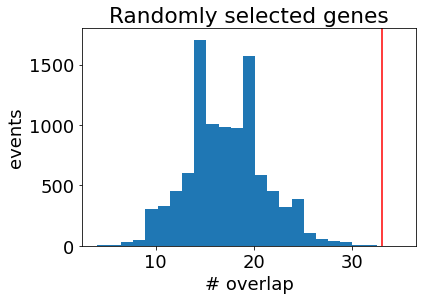

In [194]:
plt.rcParams.update({'font.size':18})
plt.hist(overlap_cnt, bins = 25)
plt.vlines(33, ymin=0,ymax=1800, color = 'r')
plt.ylim(0,1800)
plt.title('Randomly selected genes')
plt.ylabel('events')
plt.xlabel('# overlap');

In [186]:
print('Probability of getting >= 33 overlapping genes:')
print(sum(np.array(overlap_cnt) > 30)/10000)

Probability of getting >= 33 overlapping genes:
0.0016


## Random selection to determine probability of the observed overlap between critical gene regulators and DEGs

## Determine DEGs that regulate the critical genes or neighbor genes

In [23]:
# Use Nihal's definition of DEGs (padj < 0.05)
print('critical gene regulators that are DEGs')
set(deseq[deseq['padj'] < 0.05]['gene']).intersection(cg_regulators['ï..Upstream.Regulator'])

critical gene regulators that are DEGs


{'CCND1', 'CXCL12', 'JAM2', 'ODC1'}

In [24]:
print('neighbor gene regulators that are DEGs')
set(deseq[deseq['padj'] < 0.05]['gene']).intersection(neigh_regulators['ï..Upstream.Regulator'])

neighbor gene regulators that are DEGs


{'ALDH1L1', 'ERBB2'}

In [207]:
overlap_cnt2 = []
for i in range(10000):
    random_genes = all_gene_symbols.sample(457) # randomly select 457 genes from all the genes in the network (to mimic the critical gene regulators)
    overlap_cnt2.append(len(set(random_genes).intersection(deseq[deseq['padj'] < 0.05]['gene']))) # how much of these randomly selected genes overlap with the deg regulators

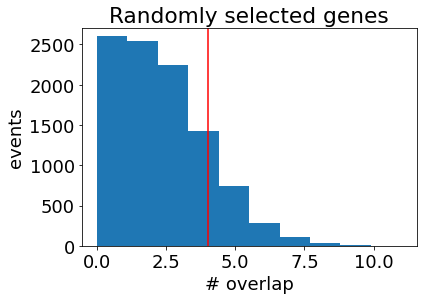

In [213]:
plt.rcParams.update({'font.size':18})
plt.hist(overlap_cnt2)
plt.vlines(4, ymin=0,ymax=2700, color = 'r')
plt.ylim(0,2700)
plt.title('Randomly selected genes')
plt.ylabel('events')
plt.xlabel('# overlap');

In [212]:
print('Probability of getting >= 33 overlapping genes:')
print(sum(np.array(overlap_cnt) > 4)/10000)

Probability of getting >= 33 overlapping genes:
0.1847


# Overlap between rat AUD genes (from Laura) and human critical genes

In [3]:
rat_aud_genes = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/IPA analysis/alcohol_genes_141.csv')

In [11]:
rat_aud_in_human = rat_aud_genes[rat_aud_genes['Symbol'].str.upper().isin(list(all_gene_symbols))]

In [12]:
len(rat_aud_in_human)

90

In [251]:
print('rat AUD overlap with critical genes')
set(rat_aud_in_human['Symbol'].str.upper()).intersection(cg_symbols)

rat AUD overlap with critical genes


{'CHRNA4', 'CHRNA6', 'CRHR2', 'FYN', 'GRM4', 'TLR2', 'TRPV1'}

In [245]:
len(set(rat_aud_in_human['Symbol'].str.upper()).intersection(cg_symbols))

7

In [252]:
print('rat AUD overlap with neighbor genes')
set(rat_aud_in_human['Symbol'].str.upper()).intersection(neighbors_symbols)

rat AUD overlap with neighbor genes


{'ADIPOR2', 'AGT', 'CHRNA6', 'GABRA1', 'MAOA', 'NTSR2', 'SLC1A3', 'TGFA'}

In [246]:
len(set(rat_aud_in_human['Symbol'].str.upper()).intersection(neighbors_symbols))

8

In [253]:
print('rat AUD overlap with DEGs')
set(rat_aud_in_human['Symbol'].str.upper()).intersection(deseq[deseq['padj'] < 0.05]['gene'])

rat AUD overlap with DEGs


set()

# Overlap between rat AUD genes (from Laura) and mouse critical genes

In [95]:
illmina_manifest = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/mousewg-6_v2_0_r3_11278593_a_txt.zip',
                               compression='zip', sep = '\t', skiprows=8, low_memory = False)

In [96]:
illmina_manifest.columns

Index(['Species', 'Source', 'Search_Key', 'Transcript', 'ILMN_Gene',
       'Source_Reference_ID', 'RefSeq_ID', 'Unigene_ID', 'Entrez_Gene_ID',
       'GI', 'Accession', 'Symbol', 'Protein_Product', 'Probe_Id',
       'Array_Address_Id', 'Probe_Type', 'Probe_Start', 'Probe_Sequence',
       'Chromosome', 'Probe_Chr_Orientation', 'Probe_Coordinates', 'Cytoband',
       'Definition', 'Ontology_Component', 'Ontology_Process',
       'Ontology_Function', 'Synonyms', 'Obsolete_Probe_Id'],
      dtype='object')

In [106]:
illmina_dict = pd.Series(illmina_manifest['Symbol'].values , index = illmina_manifest['Probe_Id']).to_dict()

In [113]:
mouse_cg_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/feature_extraction_derived/PFC_epoch=100_alpha=0.1_critical_gene_df.csv')
pfc_neighbor_df = pd.read_csv(prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/feature_extraction_derived/top_645_neighbor_genes.csv')
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')
pfc_expression = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/PFC_HDID_norm_exp.txt', sep = '\t')

In [130]:
de_data.head()

,id,gene,log2FoldChange,padj
0,ILMN_2862111,Hmgn2,1.780745,0.000362
1,ILMN_2634349,Arhgap35,-1.546438,0.000996
2,ILMN_1229634,Usp29,1.502853,0.001677
3,ILMN_2507182,Tomm22,2.220878,0.001849
4,ILMN_2601928,Pnmal1,1.278039,0.002384


In [117]:
# map all the illumina tags to mouse symbols
mouse_cg_symbols = mouse_cg_df['gene'].map(illmina_dict)
mouse_neighbor_symbols = pfc_neighbor_df['gene'].map(illmina_dict)
pfc_symbols = pfc_expression['id'].map(illmina_dict)

In [156]:
# Using padj < 0.05 gives only 16 genes. 
# By increasing padj up to 0.9, there were 363 DEGs and still just 1 overlap with the rat AUD
de_symbols = de_data[de_data['padj'] < 0.9]['id'].map(illmina_dict)

In [157]:
len(de_symbols)

363

In [123]:
# rat AUD genes present in the expression used to construct the mouse network
rat_aud_in_mouse = rat_aud_genes[rat_aud_genes['Symbol'].isin(list(pfc_symbols.unique()))]

In [124]:
print('# rat AUD genes in the PFC mouse expression')
len(rat_aud_in_mouse)

# rat AUD genes in the PFC mouse expression


45

In [125]:
print('rat AUD overlap with critical genes')
set(rat_aud_in_mouse['Symbol']).intersection(mouse_cg_symbols)

rat AUD overlap with critical genes


{'Ctsf', 'Pdyn', 'Prkg2'}

In [126]:
print('rat AUD overlap with neighbor genes')
set(rat_aud_in_mouse['Symbol']).intersection(mouse_neighbor_symbols)

rat AUD overlap with neighbor genes


{'Adcy1', 'Rab3a'}

In [158]:
print('rat AUD overlap with DEGs')
set(rat_aud_in_mouse['Symbol']).intersection(de_symbols)

rat AUD overlap with DEGs


{'Ntsr1'}